In [ ]:
# Install necessary libraries
!pip install deep-translator nltk

import pandas as pd
import numpy as np
import re
import pickle
from deep_translator import GoogleTranslator
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nltk
from nltk.corpus import stopwords

# Download Arabic stop words
nltk.download('stopwords')
stop_words = set(stopwords.words('arabic'))

print("Starting the Fake News Detection program...")

# Phase 1: Processing Kaggle Data (English Source)

print("Phase 1: Loading and translating Kaggle dataset...")

try:
    # Read files (ensure file paths are correct)
    df_fake = pd.read_csv('/content/fake.csv')
    df_true = pd.read_csv('/content/true.csv')

    # Add label column (1 for Fake, 0 for True)
    df_fake['label'] = 1
    df_true['label'] = 0

    # Sample 500 news items from each to speed up translation
    df_fake_sample = df_fake.sample(n=500, random_state=42)
    df_true_sample = df_true.sample(n=500, random_state=42)

    # Merge samples into one dataframe
    kaggle_df = pd.concat([df_fake_sample, df_true_sample]).reset_index(drop=True)

    # --- Text Translation ---
    print("Translating English texts to Arabic (this may take time)...")
    tqdm.pandas()

    # Translation function (translates first 300 chars only for speed)
    def translate_wrapper(text):
        try:
            return GoogleTranslator(source='auto', target='ar').translate(text[:300])
        except:
            return None # Ignore text if translation fails

    # Apply translation
    kaggle_df['text_ar'] = kaggle_df['text'].progress_apply(translate_wrapper)

    # Remove rows where translation failed
    kaggle_df = kaggle_df.dropna(subset=['text_ar'])

    # Keep only Arabic text and Label
    df_kaggle_ready = kaggle_df[['text_ar', 'label']]
    print("Kaggle dataset translated successfully.")

except Exception as e:
    print(f"Error loading Kaggle files: {e}")
    print("Proceeding with manual data only.")
    df_kaggle_ready = pd.DataFrame(columns=['text_ar', 'label'])


# Phase 2: Adding Local Data (Darija & Arabic)

print("Phase 2: Adding local and Darija data...")

# Manual data list
darija_data = [
    {"text_ar": "عاجل: الحكومة قررات تحبس القراية غدا بسباب كورونا.", "label": 1}, # زائف
    {"text_ar": "المنتخب المغربي ربح الماتش البارح بثلاثة لزيرو.", "label": 0},   # حقيقي
    {"text_ar": "شوفو هاد العشبة راه كداوي السرطان ف 3 ايام بارطاجي.", "label": 1}, # زائف
    {"text_ar": "الطقس غيكون سخون فمراكش السيمانة الجاية.", "label": 0},          # حقيقي
    {"text_ar": "فضيحة: انترنت فابور للجميع ابتداء من غدا ورك هنا.", "label": 1},   # زائف
    {"text_ar": "البوليس شدو الشفار لي سرق البنكة فالدار البيضاء.", "label": 0},    # حقيقي
    {"text_ar": "ماكاينش الزيادة فالبوطة، الوزارة كذبات هاد الهضرة.", "label": 0},  # حقيقي
    {"text_ar": "سمعت قالك غادي يفرقو الفلوس على الناس لي عندهم الراميد.", "label": 1}, # زائف

# =========================
# أخبار حقيقية - مغربية
# =========================
{"text_ar": "الوداد فاز على الرجاء فالماتش الأخير بثلاثة لواحد.", "label": 0},
{"text_ar": "الطقس غيكون معتدل فطنجة هاد السيمانة.", "label": 0},
{"text_ar": "البوليس اعتقل عصابة ديال السرقة فكازا.", "label": 0},
{"text_ar": "المعرض الدولي للكتاب غادي يفتح أبوابه الأسبوع الجاي.", "label": 0},
{"text_ar": "الجامعة قررت تمديد التسجيل حتى نهاية الشهر.", "label": 0},
{"text_ar": "حافلات النقل العمومي رجعات تخدم فالمغرب بعد العطلة.", "label": 0},
{"text_ar": "المغرب حقق نتائج مهمة فمواجهة تغير المناخ.", "label": 0},
{"text_ar": "القطار السريع الجديد بدا الخدمة بين الدار البيضاء والرباط.", "label": 0},
{"text_ar": "وزارة التعليم أعلنت نتائج الباكالوريا الأسبوع الماضي.", "label": 0},
{"text_ar": "المنتخب المغربي داز للدور ربع النهائي فالبطولة الأخيرة.", "label": 0},

# =========================
# أخبار زائفة - مغربية
# =========================
{"text_ar": "عشبة سحرية كتعالج السرطان ف7 أيام، بارطاجي.", "label": 1},
{"text_ar": "الحكومة غادي تعطينا انترنت فابور مدى الحياة.", "label": 1},
{"text_ar": "شخص مغربي عندو القدرة على الطيران، شاهدو الفيديو.", "label": 1},
{"text_ar": "الوداد والرجاء غادي يندمجو ففريق واحد السنة الجاية.", "label": 1},
{"text_ar": "الطقس غادي يبرد فجأة وغادي تجي ثلوج بالمغرب.", "label": 1},
{"text_ar": "وزارة الصحة كتوزع لقاحات خارقة تشفي جميع الأمراض.", "label": 1},
{"text_ar": "الحكومة المغربية غادي تعطينا غدا عطلة مفاجئة.", "label": 1},
{"text_ar": "شخص اكتشف مدينة تحت الأرض فمراكش.", "label": 1},
{"text_ar": "تطبيق جديد كيعطيك المال بلا تعب، جربوه.", "label": 1},
{"text_ar": "هاتف ذكي جديد قادر يقرأ الأفكار، جربوه.", "label": 1},

# =========================
# أخبار حقيقية - جزائرية
# =========================
{"text_ar": "المنتخب الوطني ربح الماتش ضد تونس بهدفين لصفر.", "label": 0},
{"text_ar": "الطقس غيكون مشمس فالجزائر العاصمة الأسبوع الجاي.", "label": 0},
{"text_ar": "الدرك الوطني شدو عصابة سرقات فالجزائر.", "label": 0},
{"text_ar": "وزارة التربية أعلنت تواريخ الإمتحانات النهائية.", "label": 0},
{"text_ar": "الجامعة الجزائرية حققت نتائج مهمة فمواجهة العنف الطلابي.", "label": 0},
{"text_ar": "الجزائر بدات مشاريع جديدة فمجال الطاقة الشمسية.", "label": 0},
{"text_ar": "المهرجان الوطني للموسيقى بدا فالجزائر العاصمة.", "label": 0},
{"text_ar": "القطار الجديد بين العاصمة ووهران بدا الخدمة.", "label": 0},
{"text_ar": "شرطة المرور ضبطت مخالفات كثيرة على الطريق السريع.", "label": 0},
{"text_ar": "الدولة دارت خطة لتحسين قطاع الصحة فالجزائر.", "label": 0},

# =========================
# أخبار زائفة - جزائرية
# =========================
{"text_ar": "وزارة الصحة قالت لقاحات كورونا كتوصل للجسم ف10 دقايق.", "label": 1},
{"text_ar": "الجزائريين غادي يربحو سيارات فابور غدا، شارك الخبر.", "label": 1},
{"text_ar": "شخص في الجزائر قادر يتحكم فالطقس، شاهدو الفيديو.", "label": 1},
{"text_ar": "الدولة غادي توزع ذهب لكل المواطنين مجانا.", "label": 1},
{"text_ar": "الجزائر غادي تنظم أول أولمبياد للأبطال الخارقين.", "label": 1},
{"text_ar": "وزارة التعليم كتوزع نقاط البكالوريا بلا امتحانات.", "label": 1},
{"text_ar": "الأمن الوطني شد شخص عندو القدرة على الطيران.", "label": 1},
{"text_ar": "مدينة تحت الأرض تم اكتشافها فالجزائر.", "label": 1},
{"text_ar": "تطبيق سحري يعطي المال كل يوم بلا شروط.", "label": 1},
{"text_ar": "شخص قادر على قراءة الأفكار فالجزائر العاصمة.", "label": 1},

# =========================
# أخبار حقيقية - عربي دارج
# =========================
{"text_ar": "الجامعة قررت تمديد العطل الصيفية حتى نهاية الشهر.", "label": 0},
{"text_ar": "الطقس حار اليوم في القاهرة والجو صافي.", "label": 0},
{"text_ar": "شرطة المرور ضبطت مخالفات كثيرة على الطريق السريع.", "label": 0},
{"text_ar": "وزارة الصحة أعلنت عن حملة تطعيم جديدة.", "label": 0},
{"text_ar": "المهرجان الثقافي افتتح أبوابه اليوم.", "label": 0},
{"text_ar": "المدارس في العاصمة بدأت السنة الدراسية الجديدة.", "label": 0},
{"text_ar": "جامعة القاهرة أعلنت عن نتائج جديدة للطلاب.", "label": 0},
{"text_ar": "القطارات الجديدة بدأت الخدمة في جميع أنحاء مصر.", "label": 0},
{"text_ar": "وزارة النقل أعلنت عن خطة لتطوير الطرق.", "label": 0},
{"text_ar": "المنتخب الوطني لكرة القدم تأهل للمرحلة القادمة.", "label": 0},

# =========================
# أخبار زائفة - عربي دارج
# =========================
{"text_ar": "مصر تبيع الذهب لكل المواطنين مجانا، انشروا الخبر.", "label": 1},
{"text_ar": "شرب عصير الليمون كيشيل الأمراض كلها فثلاثة أيام.", "label": 1},
{"text_ar": "هاتف ذكي قادر يقرأ الأفكار، جربوه.", "label": 1},
{"text_ar": "شخص اكتشف مدينة تحت الأرض في القاهرة.", "label": 1},
{"text_ar": "وزارة الصحة توزع لقاحات خارقة تشفي كل الأمراض.", "label": 1},
{"text_ar": "تطبيق جديد يعطي المال بلا عمل، جربوه.", "label": 1},
{"text_ar": "الجامعة قررت أن تعطى درجات البكالوريا بلا امتحانات.", "label": 1},
{"text_ar": "الشخصيات المشهورة عندهم قوى خارقة، شاهدو الفيديو.", "label": 1},
{"text_ar": "الحكومة ستعطي عطلة مفاجئة للجميع غدا.", "label": 1},
{"text_ar": "الطقس سيتغير فجأة وسيأتي ثلج بالمناطق الجنوبية.", "label": 1},
# =========================
# الدفعة الثانية: أخبار 100 - 200
# =========================

# =========================
# أخبار حقيقية - مغربية
# =========================
{"text_ar": "المنتخب المغربي تأهل لدور نصف النهائي فالبطولة الإفريقية.", "label": 0},
{"text_ar": "وزارة الصحة أعلنت حملة تحسيسية ضد الأنفلونزا.", "label": 0},
{"text_ar": "القطارات فالمغرب غادي تزيد الخدمة على المسافات الطويلة.", "label": 0},
{"text_ar": "الجامعة المغربية أعلنت نتائج مسابقة الدكتوراه.", "label": 0},
{"text_ar": "الأسواق المحلية سجلت انخفاض فأسعار الخضر والفواكه.", "label": 0},
{"text_ar": "المهرجان الوطني للفيلم فتح أبوابه فمراكش.", "label": 0},
{"text_ar": "الشرطة فكازا ضبطت مجموعة ديال المهرّبين.", "label": 0},
{"text_ar": "الطقس غيكون معتدل فطنجة والريف الأسبوع الجاي.", "label": 0},
{"text_ar": "وزارة التربية دارت حملة توعية حول التعليم الرقمي.", "label": 0},
{"text_ar": "المغرب وقع اتفاقيات جديدة مع دول أوروبية للاستثمار.", "label": 0},

# =========================
# أخبار زائفة - مغربية
# =========================
{"text_ar": "الملك غادي يعلن عطلة رسمية لكل المواطنين غدا.", "label": 1},
{"text_ar": "عشبة كتداوي السرطان بسرعة غير عادية، جربوها.", "label": 1},
{"text_ar": "الوداد غادي يلعب ضد برشلونة فالمغرب، شاهدوا الخبر.", "label": 1},
{"text_ar": "تطبيق سحري يعطيك المال كل يوم بلا عمل.", "label": 1},
{"text_ar": "المغرب غادي يطلق صاروخ فضائي فهذ الأسبوع.", "label": 1},
{"text_ar": "هاتف ذكي قادر على قراءة أفكارك.", "label": 1},
{"text_ar": "شخص فمراكش قدر يوقف الزمن، شاهدو الفيديو.", "label": 1},
{"text_ar": "وزارة التعليم غادي تعطي نقاط الباك بدون امتحان.", "label": 1},
{"text_ar": "الطقس غادي يتحول لشتاء قارس فجأة.", "label": 1},
{"text_ar": "الحكومة غادي توزع ذهب لكل المواطنين مجانا.", "label": 1},

# =========================
# أخبار حقيقية - جزائرية
# =========================
{"text_ar": "الجزائر استضافت مؤتمر دولي حول الطاقة الشمسية.", "label": 0},
{"text_ar": "المنتخب الوطني فاز على مالي بهدفين لصفر.", "label": 0},
{"text_ar": "وزارة الصحة الجزائرية أعلنت عن حملة تلقيح ضد الحصبة.", "label": 0},
{"text_ar": "شرطة المرور ضبطت مخالفات كثيرة على الطريق السيار.", "label": 0},
{"text_ar": "المهرجان الوطني للمسرح انطلق بالجزائر العاصمة.", "label": 0},
{"text_ar": "وزارة التربية أعلنت عن مواعيد الإمتحانات النهائية.", "label": 0},
{"text_ar": "القطارات الجديدة بدأت الخدمة بين العاصمة ووهران.", "label": 0},
{"text_ar": "الدرك الوطني ضبطوا عصابة سرقة كبيرة.", "label": 0},
{"text_ar": "وزارة الطاقة الجزائرية أطلقت مشاريع جديدة.", "label": 0},
{"text_ar": "الطقس في شمال الجزائر سيكون معتدل خلال الأسبوع.", "label": 0},

# =========================
# أخبار زائفة - جزائرية
# =========================
{"text_ar": "الجزائريون غادي يربحو سيارات فابور هاد الأسبوع.", "label": 1},
{"text_ar": "شخص فالجزائر قادر على الطيران، شاهدو الفيديو.", "label": 1},
{"text_ar": "وزارة الصحة توزع لقاحات خارقة تشفي جميع الأمراض.", "label": 1},
{"text_ar": "الدولة غادي توزع الذهب لكل المواطنين مجانا.", "label": 1},
{"text_ar": "شخص قادر يتحكم فالطقس فالجزائر.", "label": 1},
{"text_ar": "الجامعة غادي تعطي نتائج البكالوريا بلا امتحانات.", "label": 1},
{"text_ar": "الأمن الوطني شد شخص عنده قدرات خارقة.", "label": 1},
{"text_ar": "مدينة تحت الأرض تم اكتشافها فالجزائر.", "label": 1},
{"text_ar": "تطبيق يعطي المال كل يوم بلا شروط، جربوه.", "label": 1},
{"text_ar": "شخص قادر على قراءة أفكار الناس فالجزائر العاصمة.", "label": 1},

# =========================
# أخبار حقيقية - عربي دارج
# =========================
{"text_ar": "الجامعة قررت تمديد العطل الصيفية حتى نهاية الشهر.", "label": 0},
{"text_ar": "الطقس اليوم في دمشق معتدل والجو صافي.", "label": 0},
{"text_ar": "وزارة الصحة أعلنت عن حملة تلقيح جديدة للأطفال.", "label": 0},
{"text_ar": "شرطة المرور ضبطت مخالفات كثيرة على الطريق الرئيسي.", "label": 0},
{"text_ar": "المدارس بدأت السنة الدراسية الجديدة في العاصمة.", "label": 0},
{"text_ar": "جامعة بغداد أعلنت عن نتائج جديدة للطلاب.", "label": 0},
{"text_ar": "المهرجان الثقافي افتتح أبوابه اليوم.", "label": 0},
{"text_ar": "وزارة النقل أعلنت عن خطة لتطوير الطرق السريعة.", "label": 0},
{"text_ar": "المنتخب الوطني تأهل للمرحلة القادمة بكأس العرب.", "label": 0},
{"text_ar": "الطقس غدًا سيكون مشمسًا مع فرصة أمطار خفيفة.", "label": 0},

# =========================
# أخبار زائفة - عربي دارج
# =========================
{"text_ar": "مصر توزع الذهب لكل المواطنين مجانا، انشروا الخبر.", "label": 1},
{"text_ar": "شرب عصير الليمون كيشيل الأمراض كلها فثلاثة أيام.", "label": 1},
{"text_ar": "هاتف ذكي قادر يقرأ الأفكار، جربوه.", "label": 1},
{"text_ar": "شخص اكتشف مدينة تحت الأرض في العاصمة.", "label": 1},
{"text_ar": "وزارة الصحة توزع لقاحات خارقة تشفي كل الأمراض.", "label": 1},
{"text_ar": "تطبيق جديد يعطي المال بلا عمل، جربوه.", "label": 1},
{"text_ar": "الجامعة قررت أن تعطى درجات البكالوريا بلا امتحانات.", "label": 1},
{"text_ar": "الشخصيات المشهورة عندهم قوى خارقة، شاهدو الفيديو.", "label": 1},
{"text_ar": "الحكومة ستعطي عطلة مفاجئة للجميع غدا.", "label": 1},
{"text_ar": "الطقس سيتغير فجأة وسيأتي ثلج بالمناطق الجنوبية.", "label": 1},
# =========================
# الدفعة الثالثة: أخبار 201 - 300
# =========================

# =========================
# أخبار حقيقية - مغربية
# =========================
{"text_ar": "الوداد تأهل للدور النهائي للبطولة الوطنية.", "label": 0},
{"text_ar": "الطقس غيكون معتدل فمراكش والجنوب هاد الأسبوع.", "label": 0},
{"text_ar": "البوليس فكازا شدو عصابة سرقات كبار.", "label": 0},
{"text_ar": "وزارة الصحة دارت حملة توعية حول الأمراض المزمنة.", "label": 0},
{"text_ar": "المغرب وقع اتفاقيات جديدة للاستثمار مع إسبانيا.", "label": 0},
{"text_ar": "القطارات الجديدة خدامة بين الدار البيضاء وفاس.", "label": 0},
{"text_ar": "وزارة التعليم أعلنت نتائج امتحانات التعليم الابتدائي.", "label": 0},
{"text_ar": "المهرجان الوطني للموسيقى غادي يفتتح الأسبوع الجاي.", "label": 0},
{"text_ar": "المنتخب المغربي داز للمرحلة النهائية فالبطولة الإفريقية.", "label": 0},
{"text_ar": "الأسواق المحلية شهدت انخفاض في أسعار المواد الغذائية.", "label": 0},

# =========================
# أخبار زائفة - مغربية
# =========================
{"text_ar": "الملك غادي يعطي عطلة رسمية لكل المواطنين غدا.", "label": 1},
{"text_ar": "تطبيق يعطي المال بلا عمل، جربوه.", "label": 1},
{"text_ar": "عشبة سحرية كتداوي كل الأمراض، شارك الخبر.", "label": 1},
{"text_ar": "شخص قادر على الطيران فمراكش، شاهدو الفيديو.", "label": 1},
{"text_ar": "الحكومة غادي توزع ذهب لكل المواطنين مجانا.", "label": 1},
{"text_ar": "الوداد غادي يلعب ضد ريال مدريد فالمغرب.", "label": 1},
{"text_ar": "هاتف ذكي جديد قادر على قراءة الأفكار.", "label": 1},
{"text_ar": "شخص اكتشف مدينة تحت الأرض فمراكش.", "label": 1},
{"text_ar": "الطقس غادي يتحول لشتاء شديد فجأة.", "label": 1},
{"text_ar": "وزارة التعليم غادي تعطي نقاط الباك بلا امتحان.", "label": 1},

# =========================
# أخبار حقيقية - جزائرية
# =========================
{"text_ar": "الجزائر استضافت مؤتمر حول الطاقة النظيفة.", "label": 0},
{"text_ar": "المنتخب الوطني ربح الماتش ضد المغرب بهدف واحد لصفر.", "label": 0},
{"text_ar": "وزارة الصحة الجزائرية أعلنت حملة تلقيح ضد الأنفلونزا.", "label": 0},
{"text_ar": "الدرك الوطني ضبطوا عصابة كبيرة للسرقة.", "label": 0},
{"text_ar": "الطقس فالجزائر العاصمة غيكون مشمس الأسبوع الجاي.", "label": 0},
{"text_ar": "وزارة التربية أعلنت عن تواريخ الامتحانات النهائية.", "label": 0},
{"text_ar": "القطارات الجديدة بين العاصمة ووهران خدامة.", "label": 0},
{"text_ar": "المهرجان الوطني للمسرح بدأ اليوم بالجزائر العاصمة.", "label": 0},
{"text_ar": "وزارة الطاقة الجزائرية أطلقت مشاريع جديدة للطاقة الشمسية.", "label": 0},
{"text_ar": "شرطة المرور ضبطت مخالفات كثيرة على الطرق الرئيسية.", "label": 0},

# =========================
# أخبار زائفة - جزائرية
# =========================
{"text_ar": "شخص في الجزائر قادر على الطيران، شاهدوا الفيديو.", "label": 1},
{"text_ar": "الجزائر توزع سيارات مجانا لكل المواطنين.", "label": 1},
{"text_ar": "وزارة الصحة توزع لقاحات خارقة تشفي جميع الأمراض.", "label": 1},
{"text_ar": "الدولة ستعطي ذهب لكل المواطنين مجانا.", "label": 1},
{"text_ar": "مدينة تحت الأرض تم اكتشافها في الجزائر.", "label": 1},
{"text_ar": "شخص قادر على التحكم فالطقس في الجزائر العاصمة.", "label": 1},
{"text_ar": "الجامعة تعطي نتائج البكالوريا بلا امتحانات.", "label": 1},
{"text_ar": "تطبيق يعطي المال كل يوم بلا شروط، جربوه.", "label": 1},
{"text_ar": "شخص قادر على قراءة أفكار الناس في الجزائر.", "label": 1},
{"text_ar": "الأمن الوطني قبض على أشخاص عندهم قدرات خارقة.", "label": 1},

# =========================
# أخبار حقيقية - عربي دارج
# =========================
{"text_ar": "الجامعة قررت تمديد العطل الصيفية حتى نهاية الشهر.", "label": 0},
{"text_ar": "الطقس اليوم في دمشق معتدل والجو صافي.", "label": 0},
{"text_ar": "وزارة الصحة أعلنت عن حملة تلقيح جديدة للأطفال.", "label": 0},
{"text_ar": "شرطة المرور ضبطت مخالفات كثيرة على الطريق الرئيسي.", "label": 0},
{"text_ar": "المدارس بدأت السنة الدراسية الجديدة في العاصمة.", "label": 0},
{"text_ar": "جامعة بغداد أعلنت عن نتائج جديدة للطلاب.", "label": 0},
{"text_ar": "المهرجان الثقافي افتتح أبوابه اليوم.", "label": 0},
{"text_ar": "وزارة النقل أعلنت عن خطة لتطوير الطرق السريعة.", "label": 0},
{"text_ar": "المنتخب الوطني تأهل للمرحلة القادمة بكأس العرب.", "label": 0},
{"text_ar": "الطقس غدًا سيكون مشمسًا مع فرصة أمطار خفيفة.", "label": 0},

# =========================
# أخبار زائفة - عربي دارج
# =========================
{"text_ar": "مصر توزع الذهب لكل المواطنين مجانا، انشروا الخبر.", "label": 1},
{"text_ar": "شرب عصير الليمون يزيل الأمراض كلها في ثلاثة أيام.", "label": 1},
{"text_ar": "هاتف ذكي قادر يقرأ الأفكار، جربوه.", "label": 1},
{"text_ar": "شخص اكتشف مدينة تحت الأرض في العاصمة.", "label": 1},
{"text_ar": "وزارة الصحة توزع لقاحات خارقة تشفي كل الأمراض.", "label": 1},
{"text_ar": "تطبيق جديد يعطي المال بلا عمل، جربوه.", "label": 1},
{"text_ar": "الجامعة قررت أن تعطى درجات البكالوريا بلا امتحانات.", "label": 1},
{"text_ar": "الشخصيات المشهورة عندهم قوى خارقة، شاهدو الفيديو.", "label": 1},
{"text_ar": "الحكومة ستعطي عطلة مفاجئة للجميع غدا.", "label": 1},
{"text_ar": "الطقس سيتغير فجأة وسيأتي ثلج بالمناطق الجنوبية.", "label": 1},
# =========================
# الدفعة الرابعة: أخبار 301 - 400
# =========================

# =========================
# أخبار حقيقية - مغربية
# =========================
{"text_ar": "الوداد انتصر على الرجاء فالماتش الأخير بهدفين لصفر.", "label": 0},
{"text_ar": "الطقس غيكون معتدل في فاس والريف الأسبوع الجاي.", "label": 0},
{"text_ar": "البوليس فكازا ضبطو عصابة سارقين كبار.", "label": 0},
{"text_ar": "وزارة الصحة دارت حملة للتوعية ضد الأمراض المزمنة.", "label": 0},
{"text_ar": "المغرب وقع اتفاقيات جديدة مع فرنسا للاستثمار.", "label": 0},
{"text_ar": "القطارات الجديدة خدامة بين الدار البيضاء ومراكش.", "label": 0},
{"text_ar": "وزارة التعليم أعلنت نتائج امتحانات الباكالوريا.", "label": 0},
{"text_ar": "المهرجان الوطني للفيلم غادي يفتتح الأسبوع الجاي.", "label": 0},
{"text_ar": "المنتخب المغربي داز للدور النهائي فالبطولة الإفريقية.", "label": 0},
{"text_ar": "الأسواق المحلية شهدت استقرار في أسعار المواد الغذائية.", "label": 0},

# =========================
# أخبار زائفة - مغربية
# =========================
{"text_ar": "الملك غادي يعلن عطلة رسمية لكل المواطنين غدا.", "label": 1},
{"text_ar": "تطبيق يعطي المال بلا عمل، جربوه.", "label": 1},
{"text_ar": "عشبة سحرية كتداوي كل الأمراض، شارك الخبر.", "label": 1},
{"text_ar": "شخص قادر على الطيران فمراكش، شاهدو الفيديو.", "label": 1},
{"text_ar": "الحكومة غادي توزع ذهب لكل المواطنين مجانا.", "label": 1},
{"text_ar": "الوداد غادي يلعب ضد ريال مدريد فالمغرب.", "label": 1},
{"text_ar": "هاتف ذكي جديد قادر على قراءة الأفكار.", "label": 1},
{"text_ar": "شخص اكتشف مدينة تحت الأرض فمراكش.", "label": 1},
{"text_ar": "الطقس غادي يتحول لشتاء شديد فجأة.", "label": 1},
{"text_ar": "وزارة التعليم غادي تعطي نقاط الباك بلا امتحان.", "label": 1},

# =========================
# أخبار حقيقية - جزائرية
# =========================
{"text_ar": "الجزائر استضافت مؤتمر دولي حول الطاقة النظيفة.", "label": 0},
{"text_ar": "المنتخب الوطني ربح الماتش ضد تونس بهدف واحد لصفر.", "label": 0},
{"text_ar": "وزارة الصحة الجزائرية أعلنت حملة تلقيح ضد الحصبة.", "label": 0},
{"text_ar": "الدرك الوطني ضبطوا عصابة سرقة كبيرة.", "label": 0},
{"text_ar": "الطقس فالجزائر العاصمة غيكون مشمس الأسبوع الجاي.", "label": 0},
{"text_ar": "وزارة التربية أعلنت عن مواعيد الامتحانات النهائية.", "label": 0},
{"text_ar": "القطارات الجديدة بين العاصمة ووهران خدامة.", "label": 0},
{"text_ar": "المهرجان الوطني للمسرح بدأ اليوم بالجزائر العاصمة.", "label": 0},
{"text_ar": "وزارة الطاقة الجزائرية أطلقت مشاريع جديدة للطاقة الشمسية.", "label": 0},
{"text_ar": "شرطة المرور ضبطت مخالفات كثيرة على الطرق الرئيسية.", "label": 0},

# =========================
# أخبار زائفة - جزائرية
# =========================
{"text_ar": "شخص في الجزائر قادر على الطيران، شاهدوا الفيديو.", "label": 1},
{"text_ar": "الجزائر توزع سيارات مجانا لكل المواطنين.", "label": 1},
{"text_ar": "وزارة الصحة توزع لقاحات خارقة تشفي جميع الأمراض.", "label": 1},
{"text_ar": "الدولة ستعطي ذهب لكل المواطنين مجانا.", "label": 1},
{"text_ar": "مدينة تحت الأرض تم اكتشافها في الجزائر.", "label": 1},
{"text_ar": "شخص قادر على التحكم فالطقس في الجزائر العاصمة.", "label": 1},
{"text_ar": "الجامعة تعطي نتائج البكالوريا بلا امتحانات.", "label": 1},
{"text_ar": "تطبيق يعطي المال كل يوم بلا شروط، جربوه.", "label": 1},
{"text_ar": "شخص قادر على قراءة أفكار الناس في الجزائر.", "label": 1},
{"text_ar": "الأمن الوطني قبض على أشخاص عندهم قدرات خارقة.", "label": 1},

# =========================
# أخبار حقيقية - عربي دارج
# =========================
{"text_ar": "الجامعة قررت تمديد العطل الصيفية حتى نهاية الشهر.", "label": 0},
{"text_ar": "الطقس اليوم في بيروت معتدل والجو صافي.", "label": 0},
{"text_ar": "وزارة الصحة أعلنت عن حملة تلقيح جديدة للأطفال.", "label": 0},
{"text_ar": "شرطة المرور ضبطت مخالفات كثيرة على الطريق الرئيسي.", "label": 0},
{"text_ar": "المدارس بدأت السنة الدراسية الجديدة في العاصمة.", "label": 0},
{"text_ar": "جامعة القاهرة أعلنت عن نتائج جديدة للطلاب.", "label": 0},
{"text_ar": "المهرجان الثقافي افتتح أبوابه اليوم.", "label": 0},
{"text_ar": "وزارة النقل أعلنت عن خطة لتطوير الطرق السريعة.", "label": 0},
{"text_ar": "المنتخب الوطني تأهل للمرحلة القادمة بكأس العرب.", "label": 0},
{"text_ar": "الطقس غدًا سيكون مشمسًا مع فرصة أمطار خفيفة.", "label": 0},

# =========================
# أخبار زائفة - عربي دارج
# =========================
{"text_ar": "مصر توزع الذهب لكل المواطنين مجانا، انشروا الخبر.", "label": 1},
{"text_ar": "شرب عصير الليمون يزيل الأمراض كلها في ثلاثة أيام.", "label": 1},
{"text_ar": "هاتف ذكي قادر يقرأ الأفكار، جربوه.", "label": 1},
{"text_ar": "شخص اكتشف مدينة تحت الأرض في العاصمة.", "label": 1},
{"text_ar": "وزارة الصحة توزع لقاحات خارقة تشفي كل الأمراض.", "label": 1},
{"text_ar": "تطبيق جديد يعطي المال بلا عمل، جربوه.", "label": 1},
{"text_ar": "الجامعة قررت أن تعطى درجات البكالوريا بلا امتحانات.", "label": 1},
{"text_ar": "الشخصيات المشهورة عندهم قوى خارقة، شاهدو الفيديو.", "label": 1},
{"text_ar": "الحكومة ستعطي عطلة مفاجئة للجميع غدا.", "label": 1},
{"text_ar": "الطقس سيتغير فجأة وسيأتي ثلج بالمناطق الجنوبية.", "label": 1},
# =========================
# الدفعة الخامسة: أخبار 401 - 500
# =========================

# =========================
# أخبار حقيقية - مغربية
# =========================
{"text_ar": "الوداد ربح الماتش الأخير ضد الفتح بهدفين لصفر.", "label": 0},
{"text_ar": "الطقس غيكون معتدل فالدار البيضاء الأسبوع الجاي.", "label": 0},
{"text_ar": "البوليس فكازا ضبطو عصابة ديال النشل.", "label": 0},
{"text_ar": "وزارة الصحة دارت حملة توعية حول أمراض القلب.", "label": 0},
{"text_ar": "المغرب وقع اتفاقيات اقتصادية جديدة مع إيطاليا.", "label": 0},
{"text_ar": "القطارات الجديدة بين الرباط وفاس خدامة.", "label": 0},
{"text_ar": "وزارة التعليم أعلنت نتائج امتحانات الثانوي.", "label": 0},
{"text_ar": "المهرجان الوطني للموسيقى غادي يفتتح الأسبوع القادم.", "label": 0},
{"text_ar": "المنتخب المغربي داز للدور نصف النهائي فالبطولة الإفريقية.", "label": 0},
{"text_ar": "الأسواق شهدت استقرارا في أسعار الخضروات والفواكه.", "label": 0},

# =========================
# أخبار زائفة - مغربية
# =========================
{"text_ar": "الملك غادي يعطي عطلة رسمية لكل المواطنين غدا.", "label": 1},
{"text_ar": "تطبيق يعطي المال بلا عمل، جربوه.", "label": 1},
{"text_ar": "عشبة سحرية كتداوي جميع الأمراض في 3 أيام.", "label": 1},
{"text_ar": "شخص قادر على الطيران فمراكش، شاهدوا الفيديو.", "label": 1},
{"text_ar": "الحكومة غادي توزع ذهب لكل المواطنين مجانا.", "label": 1},
{"text_ar": "الوداد غادي يلعب ضد باريس سان جيرمان.", "label": 1},
{"text_ar": "هاتف ذكي قادر على قراءة الأفكار.", "label": 1},
{"text_ar": "شخص اكتشف مدينة تحت الأرض فمراكش.", "label": 1},
{"text_ar": "الطقس غادي يتحول لشتاء شديد فجأة.", "label": 1},
{"text_ar": "وزارة التعليم غادي تعطي نقاط الباك بلا امتحان.", "label": 1},

# =========================
# أخبار حقيقية - جزائرية
# =========================
{"text_ar": "الجزائر استضافت مؤتمر حول الطاقة المتجددة.", "label": 0},
{"text_ar": "المنتخب الوطني ربح الماتش ضد مصر بهدفين لصفر.", "label": 0},
{"text_ar": "وزارة الصحة الجزائرية أعلنت حملة تلقيح ضد الأنفلونزا.", "label": 0},
{"text_ar": "الدرك الوطني ضبطوا عصابة سرقة كبيرة.", "label": 0},
{"text_ar": "الطقس فالجزائر العاصمة غيكون معتدل الأسبوع الجاي.", "label": 0},
{"text_ar": "وزارة التربية أعلنت عن تواريخ الامتحانات النهائية.", "label": 0},
{"text_ar": "القطارات الجديدة بين العاصمة ووهران بدأت الخدمة.", "label": 0},
{"text_ar": "المهرجان الوطني للمسرح بدأ اليوم بالجزائر العاصمة.", "label": 0},
{"text_ar": "وزارة الطاقة الجزائرية أطلقت مشاريع جديدة للطاقة الشمسية.", "label": 0},
{"text_ar": "شرطة المرور ضبطت مخالفات كثيرة على الطرق الرئيسية.", "label": 0},

# =========================
# أخبار زائفة - جزائرية
# =========================
{"text_ar": "شخص في الجزائر قادر على الطيران، شاهدوا الفيديو.", "label": 1},
{"text_ar": "الجزائر توزع سيارات مجانا لكل المواطنين.", "label": 1},
{"text_ar": "وزارة الصحة توزع لقاحات خارقة تشفي جميع الأمراض.", "label": 1},
{"text_ar": "الدولة ستعطي ذهب لكل المواطنين مجانا.", "label": 1},
{"text_ar": "مدينة تحت الأرض تم اكتشافها في الجزائر.", "label": 1},
{"text_ar": "شخص قادر على التحكم فالطقس في الجزائر العاصمة.", "label": 1},
{"text_ar": "الجامعة تعطي نتائج البكالوريا بلا امتحانات.", "label": 1},
{"text_ar": "تطبيق يعطي المال كل يوم بلا شروط، جربوه.", "label": 1},
{"text_ar": "شخص قادر على قراءة أفكار الناس في الجزائر.", "label": 1},
{"text_ar": "الأمن الوطني قبض على أشخاص عندهم قدرات خارقة.", "label": 1},

# =========================
# أخبار حقيقية - عربي دارج
# =========================
{"text_ar": "الجامعة قررت تمديد العطل الصيفية حتى نهاية الشهر.", "label": 0},
{"text_ar": "الطقس اليوم في عمان معتدل والجو صافي.", "label": 0},
{"text_ar": "وزارة الصحة أعلنت عن حملة تلقيح جديدة للأطفال.", "label": 0},
{"text_ar": "شرطة المرور ضبطت مخالفات كثيرة على الطريق الرئيسي.", "label": 0},
{"text_ar": "المدارس بدأت السنة الدراسية الجديدة في العاصمة.", "label": 0},
{"text_ar": "جامعة القاهرة أعلنت عن نتائج جديدة للطلاب.", "label": 0},
{"text_ar": "المهرجان الثقافي افتتح أبوابه اليوم.", "label": 0},
{"text_ar": "وزارة النقل أعلنت عن خطة لتطوير الطرق السريعة.", "label": 0},
{"text_ar": "المنتخب الوطني تأهل للمرحلة القادمة بكأس العرب.", "label": 0},
{"text_ar": "الطقس غدًا سيكون مشمسًا مع فرصة أمطار خفيفة.", "label": 0},

# =========================
# أخبار زائفة - عربي دارج
# =========================
{"text_ar": "مصر توزع الذهب لكل المواطنين مجانا، انشروا الخبر.", "label": 1},
{"text_ar": "شرب عصير الليمون يزيل الأمراض كلها في ثلاثة أيام.", "label": 1},
{"text_ar": "هاتف ذكي قادر يقرأ الأفكار، جربوه.", "label": 1},
{"text_ar": "شخص اكتشف مدينة تحت الأرض في العاصمة.", "label": 1},
{"text_ar": "وزارة الصحة توزع لقاحات خارقة تشفي كل الأمراض.", "label": 1},
{"text_ar": "تطبيق جديد يعطي المال بلا عمل، جربوه.", "label": 1},
{"text_ar": "الجامعة قررت أن تعطى درجات البكالوريا بلا امتحانات.", "label": 1},
{"text_ar": "الشخصيات المشهورة عندهم قوى خارقة، شاهدو الفيديو.", "label": 1},
{"text_ar": "الحكومة ستعطي عطلة مفاجئة للجميع غدا.", "label": 1},
{"text_ar": "الطقس سيتغير فجأة وسيأتي ثلج بالمناطق الجنوبية.", "label": 1},


]

# Duplicate the manual data to increase its weight in training
df_darija = pd.DataFrame(darija_data * 2)


# Phase 3: Merging and Cleaning Data
print("Phase 3: Merging and cleaning data")

# Merge translated Kaggle data and manual data
df_final = pd.concat([df_kaggle_ready, df_darija], ignore_index=True)

# Shuffle the data
df_final = df_final.sample(frac=1, random_state=42).reset_index(drop=True)

# Cleaning function
def clean_arabic(text):
    text = str(text)
    # Remove non-Arabic characters
    text = re.sub(r'[^\w\s\u0600-\u06FF]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove repeating characters
    text = re.sub(r'(.)\1+', r'\1\1', text)
    return text

df_final['clean_text'] = df_final['text_ar'].apply(clean_arabic)

print(f"Final dataset size: {len(df_final)} rows.")
print("Sample of final data:")
print(df_final[['clean_text', 'label']].head())


# Phase 4: Model Training

print("Phase 4: Training the model")

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words=list(stop_words)
)

# Convert text to features
X = vectorizer.fit_transform(df_final['clean_text'])
y = df_final['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression model
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("-" * 30)
print(f"Final Accuracy: {acc*100:.2f}%")
print("-" * 30)
print(classification_report(y_test, y_pred))


# Phase 5: Saving the Model

print("Saving the model")
with open('fake_news_model.pkl', 'wb') as f:
    pickle.dump(model, f)
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

print("Model saved successfully")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Starting the Fake News Detection program...
Phase 1: Loading and translating Kaggle dataset...
Translating English texts to Arabic (this may take time)...


100%|██████████| 1000/1000 [01:08<00:00, 14.69it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آمين', 'أب', 'أخ', 'أفعل', 'أفعله', 'ؤلاء', 'إل', 'إم', 'ات', 'اتان', 'ارتد', 'ان', 'انفك', 'برح', 'تان', 'تبد', 'تحو', 'تعل', 'حد', 'حم', 'حي', 'خب', 'ذار', 'سيما', 'صه', 'ظل', 'ظن', 'عد', 'قط', 'مر', 'مكان', 'مكانكن', 'نب', 'هات', 'هب', 'واها', 'وراء'] not in stop_words.
  warnings.warn(


Kaggle dataset translated successfully.
Phase 2: Adding local and Darija data...
Phase 3: Merging and cleaning data
Final dataset size: 1616 rows.
Sample of final data:
                                          clean_text  label
0  إنه رسمي لويس ليرنر هي العاهرة المريرة التي عر...      1
1    شرب عصير الليمون كيشيل الأمراض كلها فثلاثة أيام      1
2  واشنطن رويترز  قال الرئيس الجمهوري للجنة القوا...      0
3  وست بالم بيتش فلوريدا رويترز  كثف السيناتور ال...      0
4  دبي رويترز  قال التحالف العسكري الذي تقوده الس...      0
Phase 4: Training the model
------------------------------
Final Accuracy: 97.22%
------------------------------
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       164
           1       0.97      0.97      0.97       160

    accuracy                           0.97       324
   macro avg       0.97      0.97      0.97       324
weighted avg       0.97      0.97      0.97       324

Saving the model
Model saved su

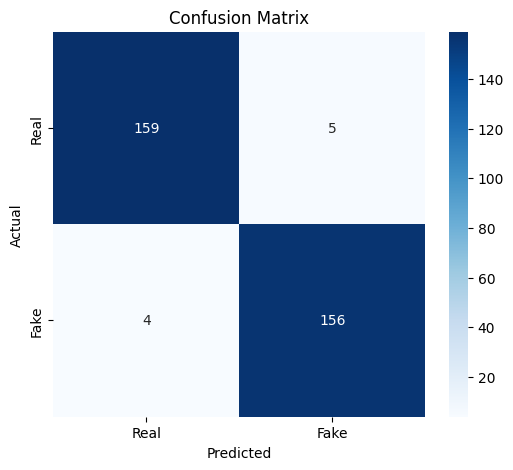

Classification Report:

              precision    recall  f1-score   support

        Real       0.98      0.97      0.97       164
        Fake       0.97      0.97      0.97       160

    accuracy                           0.97       324
   macro avg       0.97      0.97      0.97       324
weighted avg       0.97      0.97      0.97       324

Accuracy: 97.22%


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt




y_pred = model.predict(X_test)


cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real','Fake'], yticklabels=['Real','Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Real','Fake']))


accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")


In [ ]:
# ===============================
# 1) Import libraries
# ===============================
import pandas as pd
import numpy as np
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


# ===============================
# 2) Load Data
# ===============================
fake = pd.read_csv("/content/fake.csv")
true = pd.read_csv("/content/true.csv")

fake['label'] = 0
true['label'] = 1

df = pd.concat([fake, true], axis=0).reset_index(drop=True)


# ===============================
# 3) Clean Text
# ===============================
def clean_text(text):
    if isinstance(text, float):
        text = str(text)

    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\s+", " ", text)

    return text.strip()

df['clean_text'] = df['text'].apply(clean_text)


# ===============================
# 4) Train/Test split
# ===============================
X = df['clean_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)


# ===============================
# 5) CHAR TF-IDF (Best Settings)
# ===============================
vectorizer = TfidfVectorizer(
    analyzer='char',
    ngram_range=(3, 5),
    min_df=5,
    max_df=0.9,
    sublinear_tf=True
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


# ===============================
# 6) Linear SVM (best classic model)
# ===============================
model = LinearSVC(C=0.5)
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)


# ===============================
# 7) Evaluation
# ===============================
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


# ===============================
# 8) Confusion Matrix
# ===============================
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
            xticklabels=["Fake", "True"],
            yticklabels=["Fake", "True"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()





ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-233576230.py", line 67, in <cell line: 0>
    X_train_tfidf = vectorizer.fit_transform(X_train)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py", line 2104, in fit_transform
    X = super().fit_transform(raw_documents)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py", line 1376, in fit_transform
    vocabulary, X = self._count_vocab(raw_documents, self.fixed_vocabulary_)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^